Per Halvorsen   \
[pmhalvor@uio.no](mailto:pmhalvor@uio.no) \
GEO4460         

# Introduction


In this report, we will analyze the relationship between snow depth and thaw depth in Adventsdalen, Svalbard.
Specifically, we will:

- Build and compare interpolation layers of snow and thaw depth data
- Analyze how the data changes over time
- Construct linear regression models to predict thaw depth in $N$ months based on snow depth

The goal of this report is to build an understanding of different interpolation methods, and how they can be used to analyze spatial data. 
The interpolation  methods to be comapred are global polynomial interpolation, inverse distance weighting, and kriging. 


# Data

The data used for this analysis is the monthly thaw and snow measurements from Svalbard over the summer of 2007. 
These data were collected by the Norwegian Polar Institute and are available in the `data` folder.

The data contains measurements over an $11x11$ grid of evenly spaced points in the Adventsdalen valley, though not directly tied to any specific location longitude and latitude.
This means the analysis will need to be run on without an explicit coordinate system, but rather on a grid of points.

The data is stored in a DBF file, which contains the following columns:
- `XM`: The x-coordinate of the measurement location
- `YM`: The y-coordinate of the measurement location
- `SNOW200705`: Snow depth in May 2007
- `THAW200705`: Thaw depth in May 2007
- `THAW200706`: Thaw depth in June 2007
- `THAW200707`: Thaw depth in July 2007
- `THAW200708`: Thaw depth in August 2007
- `THAW200709`: Thaw depth in September 2007



# Method

## Interpolation

As mentioned above, we will be comparing three different interpolation methods: global polynomial interpolation, inverse distance weighting, and kriging. Each interpolation method can be implemented in ArcGIS using the Geostatistical Wizard. When configuring the interpolation, each method comes with unique parameters that need to be optimally set in order to achieve the best results.

### Global/Local Polynomial Interpolation (GPI/LPI)
Being the simplest of our interpolation models, global and local polynomials are fast and efficient approximations, making them ideal for situations with densely populated data that needs to be compressed or simplified. Global polynomials are more likely to focus on larger trends across the data, while local polynomials enable more granular representations. Splines are an example of local polynomials that are relatively robust against clustered data, as long as sampling can be considered fair — for example, if sparse measurements occur in smoothed terrain with little variance.

Global polynomials are usually coarse representations, making them typically very underfit compared to the other interpolation methods we’ve observed. Local polynomials are prone to overfitting and can also be quite sensitive to parameter tuning, similar to IDW. In areas of complex terrain, they may oscillate or produce artifacts that don’t reflect realistic surface features.


### Inverse Distance Weighting (IDW)
Inverse distance weighting can be a simple and exact approach to elevation mapping, requiring only a min/max neighborhood size and a power coefficient. Synonymous with a circus tent, with the internal poles representing the measured input elevations, these models are often highly intuitive. Cells of an inverse distance weighted raster are calculated from, and influenced by, their closeness to their neighbors. This preserves the local variation captured by the measurements and is typically considered robust, even over sparsely populated regions in an otherwise very clustered dataset.

A flaw of highly localized models is that they tend to focus only on a point’s immediate neighborhood and thus fail to pick up on any global trends, making them less adaptable to complex terrain. This can lead to heavily biased representations if sampling is not fairly distributed. Proper tuning is important when using IDW, since the power parameter and neighborhood sizes can be very sensitive to overfitting. To ensure generalizability, it’s good practice to tune IDW models using a validation set, ensuring the optimal parameters also achieve reasonable errors on unseen data.

### Kriging
Using the semivariance between points, kriging finds the optimal relation between how much neighboring points in the input data should influence each other. This not only makes kriging the most statistically optimal interpolation method, but also provides a variance surface, which represents each cell’s corresponding certainty. Localized predictions with certainty estimations make kriging a great method for use-cases that require fine-grained resolution with limited or sparse data.

Due to being an abstract statistic on the data, interpretability of kriging can be more cumbersome than other simpler models. To understand the trends the model is picking up on, an analyst needs to be able to interpret a semivariogram, which is not always directly intuitive. Kriging’s added complexity of fitting a variogram model and solving a system of equations for each prediction makes calculating these interpolations slower than other methods, especially when working with large data sets. These equations assume the input data has some innate statistical predictability, which might not always be the case — for example, with very noisy data, highly irregular sampling patterns, or human-influenced landscapes.



## Geoanalysis

In this section, we will analyze the trends we see in the snow melt data. 
This analysis can be done using the raw data from the DBF file or randomly selected points from our rasters, both producing very similar results.
The major difference between the two analyses would the amount of outliers in the data raw data, which might introduce bias and skew the statistical analysis.
Even though it requires a few extra steps, we'll be using sampled data from the rasters, to document this process as well, for future reference. 

For this analysis, we will leverage open-sourced Python libraries such as `numpy`, `pandas`, and `matplotlib` for efficient and reproducible results.

### Trends in thaw data 

In [ ]:
import os  
import pandas as pd
from simpledbf import Dbf5
import matplotlib.pyplot as plt


def load_snow_thaw_data_sampled(dir_path: str = "."):
    """
    Method for loading randomly sampled snow and thaw data.
    Load snow and thaw data from the specified directory.

    Args:
        dir_path (str): The path to the directory containing the data files.

    Returns:
        dict: A dictionary containing the loaded data.
    """
    expected_file_prefixes = ["SNOW", "THAW"]
    
    data = pd.DataFrame()

    for file_name in os.listdir(dir_path):
        if any(file_name.startswith(prefix) for prefix in expected_file_prefixes):
            file_path = os.path.join(dir_path, file_name)

            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    file_data = pd.read_csv(file, sep=";", header=0)
                    
                    if len(data) > 0:
                        data = pd.merge(data, file_data, how="inner", on=["random_sample","X","Y"])
                    else:
                        data = file_data
            else:
                print(f"Warning: {file_name} not found in {dir_path}")
    
    data = preprocess(data)
    return data

def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the data by renaming columns and dropping unnecessary ones.

    Args:
        data (pd.DataFrame): The data to preprocess.

    Returns:
        pd.DataFrame: The preprocessed data.
    """
    data.rename(columns={"X": "XM", "Y": "YM"}, inplace=True)
    data.drop(columns=["random_sample"], inplace=True)
    data.rename(columns=lambda col: col.replace("GPI_", "").replace("_Band_1", ""), inplace=True)
    data = data.replace(',', '.', regex=True).astype(float)
    return data

def load_snow_thaw_data_raw(dir_path: str = "."):
    """
    Method for loading raw snow and thaw data.
    Load snow and thaw data from the specified directory.

    Args:
        dir_path (str): The path to the directory containing the data files.

    Returns:
        dict: A dictionary containing the loaded data.
    """
    snow_melt_path = os.path.join(dir_path,"month_thaw_snow.dbf")

    snow_melt_dbf = Dbf5(snow_melt_path)

    return snow_melt_dbf.to_dataframe()


load_snow_thaw_data_sampled("exports")
# load_snow_thaw_data_raw("GIS4_datafiles")


,XM,YM,THAW200705,THAW200706,THAW200707,THAW200709,THAW200708,SNOW200705
0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
1,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0
2,60.0,0.0,60.0,60.0,60.0,60.0,60.0,60.0
3,70.0,0.0,70.0,70.0,70.0,70.0,70.0,70.0
4,80.0,0.0,80.0,80.0,80.0,80.0,80.0,80.0
...,...,...,...,...,...,...,...,...
95,60.0,100.0,60.0,60.0,60.0,60.0,60.0,60.0
96,70.0,100.0,70.0,70.0,70.0,70.0,70.0,70.0
97,80.0,100.0,80.0,80.0,80.0,80.0,80.0,80.0
98,90.0,100.0,90.0,90.0,90.0,90.0,90.0,90.0


In [79]:
load_snow_thaw_data_raw("GIS4_datafiles")

,XM,YM,SNOW200705,THAW200705,THAW200706,THAW200707,THAW200708,THAW200709
0,0,0,2,43,100,100,107,108
1,10,0,5,41,73,100,106,107
2,20,0,5,40,77,106,110,115
3,30,0,10,36,68,96,100,102
4,40,0,7,72,86,89,96,96
...,...,...,...,...,...,...,...,...
116,60,100,5,37,65,99,108,109
117,70,100,4,41,66,95,103,103
118,80,100,0,46,72,100,119,119
119,90,100,1,41,65,92,105,107


In [ ]:
snow_melt = load_snow_thaw_data_sampled("exports")

columns_of_interest = [col for col in snow_melt.columns if col.startswith('SNOW') or col.startswith('THAW')]

snow_melt[columns_of_interest].describe()

,THAW200705,THAW200706,THAW200707,THAW200709,THAW200708,SNOW200705
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,51.400000,51.400000,51.400000,51.400000,51.400000,51.400000
std,31.909595,31.909595,31.909595,31.909595,31.909595,31.909595
min,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
50%,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
75%,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


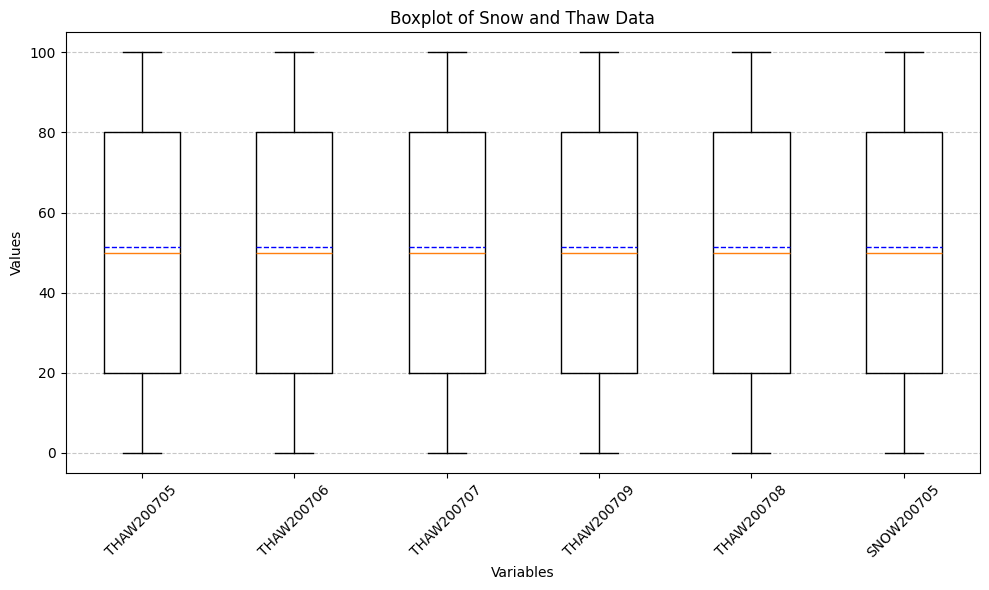

In [77]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    snow_melt[columns_of_interest], 
    tick_labels=columns_of_interest, 
    meanline=True, 
    meanprops={'color': 'blue'}, 
    showmeans=True,
)
plt.title('Boxplot of Snow and Thaw Data')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Figure X**: Box plots show the distribution of thaw data over the 5 months of measurements. 
The wider the spread, the greater the variation in thaw data across the $11\times 11$ grid. 
The yellow line shows the median value at each month, while the blue dotted line shows the mean value. 
The lower and upper limits of the box show the 25th ($Q_1$) and 75th ($Q_3$) percentiles of the data, respectively. The whiskers show the range of $1.5 \times IQR$, where $IQR=Q_3 - Q_1$. 
The circles dots outside the whiskers are the outliers in the data.

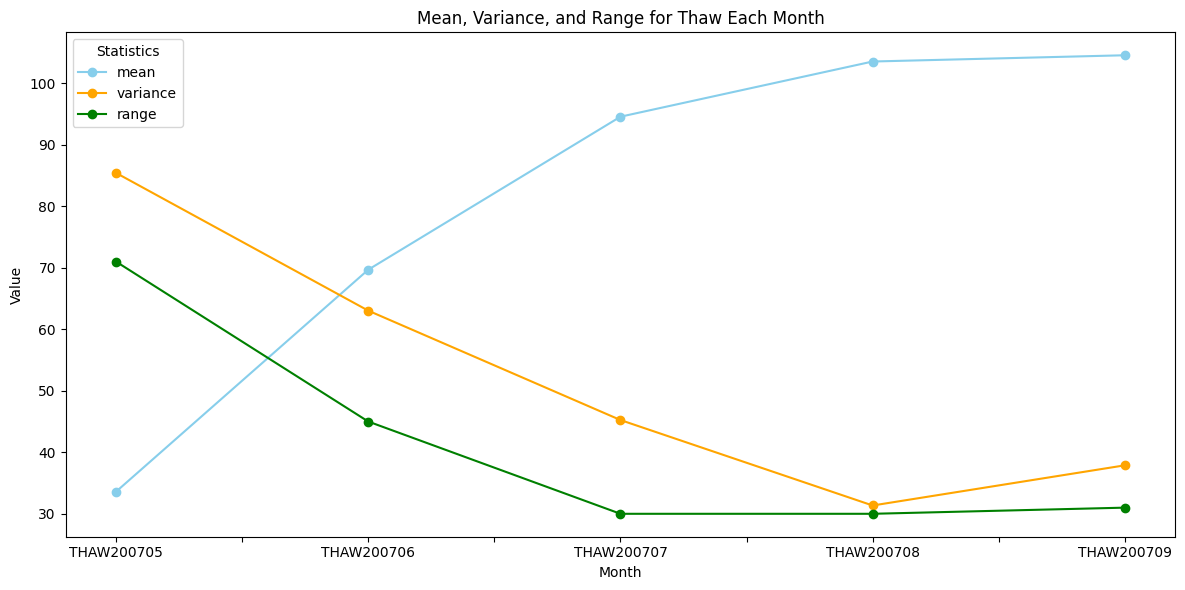

In [3]:
# Calculate descriptive statistics
stats = snow_melt[columns_of_interest].describe().T
stats['variance'] = snow_melt[columns_of_interest].var()
stats['range'] = stats['max'] - stats['min']

thaw_stats = stats[stats.index.str.startswith('THAW')]

# Plot all three statistics in the same plot
thaw_stats[['mean', 'variance', 'range']].plot(
    kind='line',
    marker='o', 
    figsize=(12, 6), 
    color=['skyblue', 'orange', 'green'], 
    title='Mean, Variance, and Range for Thaw Each Month'
)

plt.ylabel('Value')
plt.xlabel('Month')
plt.legend(title='Statistics')
plt.tight_layout()
plt.show()


**Figure X**: A simplified display of the description data from the box plot. Here, only the mean, variance and ranges for each month are shown. As the summer progresses, the mean thaw depth increases, while the variance and range of the measurements decrease. The flattening of all the curves around August and September tells us the system is becoming more stable as the summer progresses. 

### Difference in active thaw depth versus snow depth

<Figure size 1200x800 with 0 Axes>

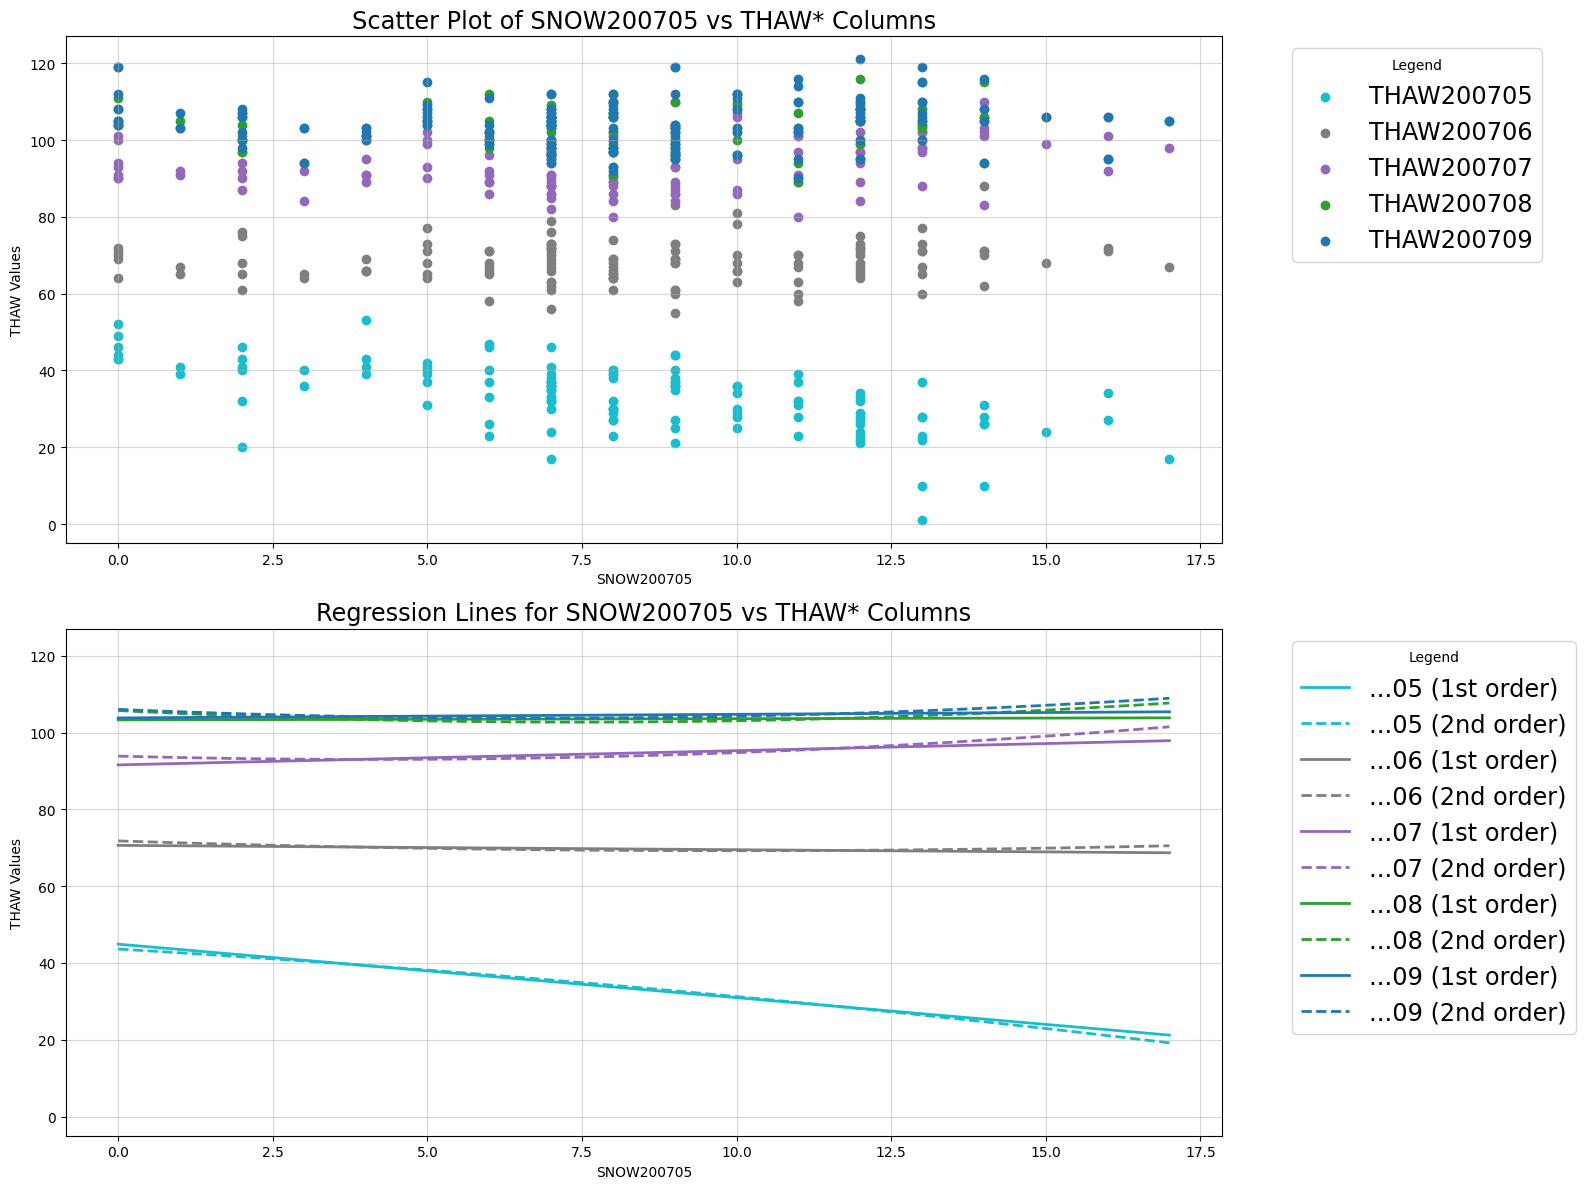

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 8))

regression_data = []

# Define a colormap
colors = plt.cm.tab10_r(np.linspace(0, 1, len([col for col in columns_of_interest if col.startswith('THAW')])))

fig, (ax_scatter, ax_regression) = plt.subplots(2, 1, figsize=(16, 12), sharey=True)

for i, thaw_column in enumerate([col for col in columns_of_interest if col.startswith('THAW')]):
    # Fit 1st, 2nd, and 3rd order polynomials
    poly1 = np.polyfit(snow_melt['SNOW200705'], snow_melt[thaw_column], 1)
    poly2 = np.polyfit(snow_melt['SNOW200705'], snow_melt[thaw_column], 2)
    poly3 = np.polyfit(snow_melt['SNOW200705'], snow_melt[thaw_column], 3)

    regression_data.append((thaw_column, poly1, poly2, poly3))
    
    # Scatter plot
    ax_scatter.scatter(snow_melt['SNOW200705'], snow_melt[thaw_column], label=f'{thaw_column}', color=colors[i])
    
    # Plot regression lines
    x = np.linspace(snow_melt['SNOW200705'].min(), snow_melt['SNOW200705'].max(), 100)
    ax_regression.plot(x, np.polyval(poly1, x), label=f'...{thaw_column[-2:]} (1st order)', linestyle='-', color=colors[i], linewidth=2)
    ax_regression.plot(x, np.polyval(poly2, x), label=f'...{thaw_column[-2:]} (2nd order)', linestyle='--', color=colors[i], linewidth=2)
    # ax_regression.plot(x, np.polyval(poly3, x), label=f'...{thaw_column[-2:]} (3rd order)', linestyle=':', color=colors[i], linewidth=2)

# Customize scatter plot axis
ax_scatter.set_title('Scatter Plot of SNOW200705 vs THAW* Columns', fontsize='xx-large')
ax_scatter.set_xlabel('SNOW200705')
ax_scatter.set_ylabel('THAW Values')
ax_scatter.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
ax_scatter.grid(alpha=0.5)

# Customize regression plot axis
ax_regression.set_title('Regression Lines for SNOW200705 vs THAW* Columns', fontsize='xx-large')
ax_regression.set_xlabel('SNOW200705')
ax_regression.set_ylabel('THAW Values')
ax_regression.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
ax_regression.grid(alpha=0.5)

plt.tight_layout()
plt.show()

<center>
    <b>Figure X</b>: Scatter plots of the data with snow depth in May along the x-axis and corresponding thaw depth in the respective months. Below are the regression lines that can be used to predict the thaw depths' correlation to snow depth. 
</center>

In [6]:
# convert regression data to DataFrame
regression_df = pd.DataFrame(regression_data, columns=['THAW Column', 'Slope', 'Intercept'])
regression_df['R-squared'] = [r_value**2 for _, _, r_value in regression_data]
regression_df['P-value'] = [p_value for _, _, p_value in regression_data]
regression_df['Standard Error'] = [std_err for _, _, std_err in regression_data]
regression_df['Significant'] = regression_df['P-value'] < 0.05

regression_df

,THAW Column,Slope,Intercept,R-squared,P-value,Standard Error,Significant
0,THAW200705,-1.393196,44.887039,2014.846264,44.887039,44.887039,False
1,THAW200706,-0.113643,70.614626,4986.425409,70.614626,70.614626,False
2,THAW200707,0.370353,91.570697,8385.192498,91.570697,91.570697,False
3,THAW200708,0.031245,103.292392,10669.318331,103.292392,103.292392,False
4,THAW200709,0.093677,103.803279,10775.120666,103.803279,103.803279,False


<center>
    <b>Table X</b>: Parameters and description statistics of the regrssion lines. 

# Analysis

## Interpolation

| Data       | Method               | RMS          |
|------------|----------------------|--------------|
| SNOW200705 | Kriging             | 4.3284e-15   |
| SNOW200705 | IDW                 | 2.5429       |
| SNOW200705 | Global (1st order)  | 1.0555e-14   |
| THAW200705 | Kriging             | 1.4913e-13   |
| THAW200705 | IDW                 | 1.9741       |
| THAW200705 | Global (1st order)  | 1.4659e-14   |
| THAW200709 | Kriging             | 1.4883e-13   |
| THAW200709 | IDW                 | 1.7719       |
| THAW200709 | Global (1st order)  | 1.1496e-14   |
<center><b>Table 1</b>: The root mean square (RMS) error of the different interpolation methods on snow and thaw data. The lower the RMS, the better the interpolation method. The same parameters were used to build each method for all three data sets.</center>


For the snow and thaw data we are analyzing, it appears that global polynomial interpolation is the most effective method. It generalizes well across all datasets and consistently produces the lowest RMS error. Since global polynomial interpolation is a global method, it is typically less prone to overfitting than local methods, which gives it an advantage in this particular use case.

Kriging was another strong candidate, but its increased complexity made it more difficult to find an optimal configuration that fit well across all layers (both snow and thaw). In this context, we prefer a model that generalizes well, as the observed local variations are minimal compared to the broader spatial trends. Since long-term or large-scale trends are the most valuable insights in this system, the simplicity and generalization ability of global polynomial interpolation make it the most appropriate choice.

## Geoanalysis
### Trends in thaw data


# Conclusion

# References